In [2]:
%matplotlib inline
import pandas as pd,seaborn as sns,matplotlib.pyplot as plt,numpy as np, glmnet_python, warnings,scipy, random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPredict import cvglmnetPredict;from cvglmnetPlot import cvglmnetPlot
from math import sqrt

# Loading the dataset as a dataframe

## use meaningfull names for your dataframes 

In [3]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

In [4]:
print(boston_dataset.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [5]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# check for missing values in dataframe and handle them

In [7]:
print('the check for missing values in this dataframe returns:'+str(boston.isnull().values.any()))

the check for missing values in this dataframe returns:False


# Check distribution of Target variable

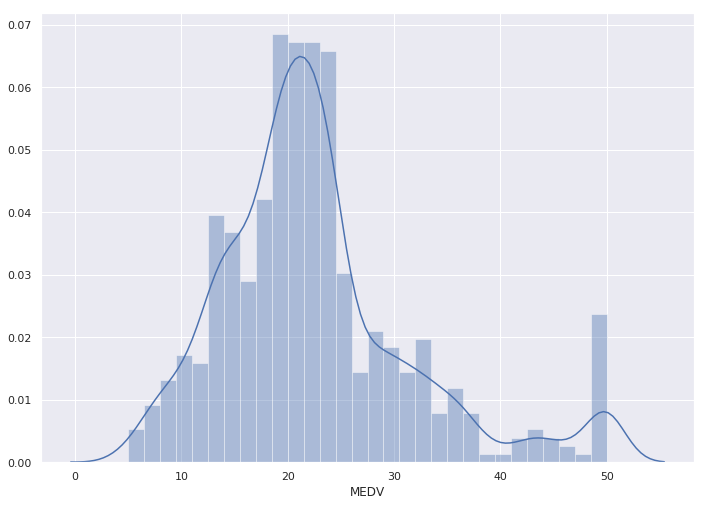

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(boston['MEDV'], bins=30)
plt.show()

# Analysis of correlations in the dataset.
## Note: Since predictive accuracy is the goal, multicollinearity is ignored.

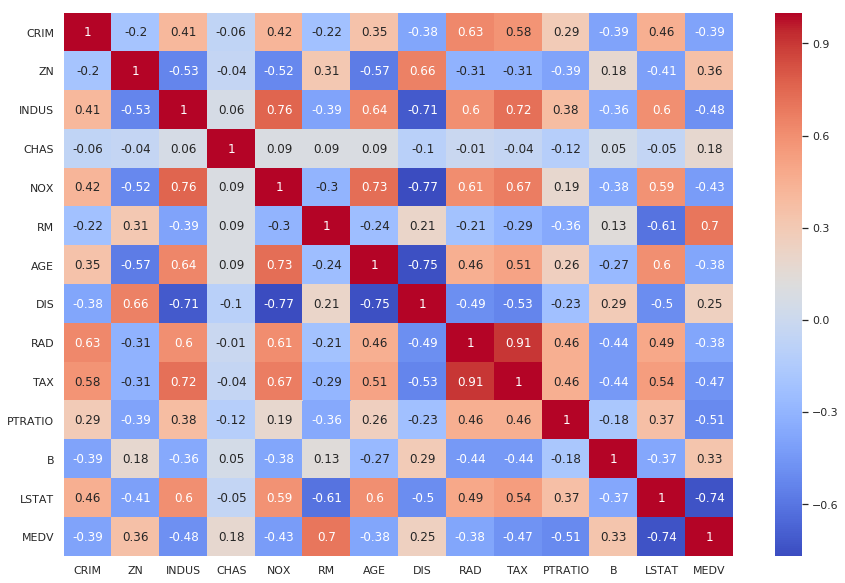

In [9]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size':12})
correlation_matrix = boston.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap="coolwarm")

# Create train- and test set

In [10]:
x=boston.loc[:,boston.columns != 'MEDV']
y=boston.loc[:,boston.columns == 'MEDV']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=34)

# Feature scaling

In [11]:
# Since the range of the Target variable is small, it is not scaled. 
# Since CHAS is a dummy variable, it is not scaled.

In [12]:
sc_x=StandardScaler()
x_train_s=pd.DataFrame(sc_x.fit_transform(x_train.loc[:,set(x.columns)-set('CHAS')]))
x_test_s=pd.DataFrame(sc_x.transform(x_test.loc[:,set(x.columns)-set('CHAS')]))
x_df=x_train.copy()

# Creating numpy arrays for model usage

In [13]:
x_train=x_train_s.copy().values
y_train=y_train.copy().values
x_test=x_test_s.copy().values
y_test=y_test.copy().values

# Baseline model: Linear regression

In [14]:
lin_reg = LinearRegression().fit(x_train, y_train)
r_sq = lin_reg.score(x_train,y_train)
r_sq_t = lin_reg.score(x_test,y_test)
y_pred = lin_reg.predict(x_test)
print('Coefficient of determination: Training Set',r_sq)
print('Coefficient of determination: Test Set',r_sq_t)
print('Root Mean Squared Error of baseline model on test set:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Coefficient of determination: Training Set 0.730434278729
Coefficient of determination: Test Set 0.745381273215
Root Mean Squared Error of baseline model on test set: 4.618160587


# Building reguralized regression models using GLMNET

At first, the default level of alpha (1.0) is used. This means LASSO regression is performed. There are 100 different levels of Lambda tries out, that will eventually set all coefficients from the original Ordinairy Least Squares (OLS, or the benchmark model) to 0.

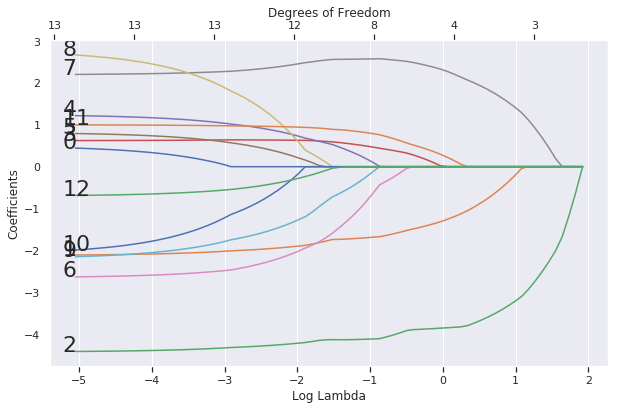

{'fig': <matplotlib.figure.Figure at 0x7f6084b24320>,
 'ax1': <matplotlib.axes._subplots.AxesSubplot at 0x7f60b52b4e10>,
 'ax2': <matplotlib.axes._subplots.AxesSubplot at 0x7f6084c697b8>}

In [15]:
fit=glmnet(x=x_train.copy(),y=y_train.copy(), family='gaussian')
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':22})
glmnetPlot(fit,xvar='lambda',label=True)

In [16]:
glmnet_pred = glmnetPredict(fit, x_test, ptype = 'response')
print(f'''The GLMNET procedure yields {len(glmnet_pred[1])} predictions per observation.This is due to the fact \
that as many levels of Lambda (s)\n have been tried before convergence occured. Next, we will use cross validation\
 to determine the optimal level of (s) \n and calculate the associated RMSE.''')

The GLMNET procedure yields 76 predictions per observation.This is due to the fact that as many levels of Lambda (s)
 have been tried before convergence occured. Next, we will use cross validation to determine the optimal level of (s) 
 and calculate the associated RMSE.


# Fit a default cross-validated GLMNET. (cross-validated LASSO) 

In [17]:
cvfit=cvglmnet(x=x_train.copy(),y=y_train.copy(),family='gaussian',ptype='mse')

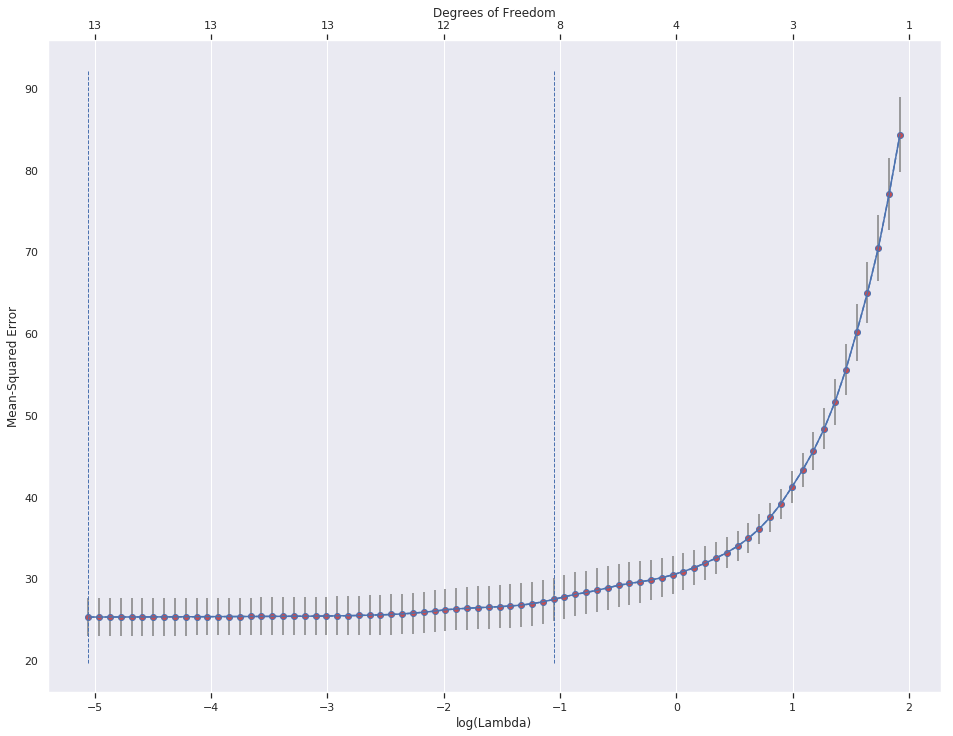

In [18]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,12))
cvglmnetPlot(cvfit)
warnings.filterwarnings('default')

From the plot above. what level of Lambda has been used to generate the absolute lowest cross-validated error? This is the left dashed blue line.

In [19]:
lambda_min=cvfit['lambda_min']
print(f'Out of the cross-validated GLMNET procedure the absolute lowest error is obtained with Lambda:{lambda_min}.')

Out of the cross-validated GLMNET procedure the absolute lowest error is obtained with Lambda:[ 0.00637665].


In [20]:
lambda_1se=cvfit['lambda_1se']
print(f'''Out of the cross-validated GLMNET procedure the lowest error within 1 standard error is obtained with
      Lambda:{lambda_1se}.This value yields the most parsimonious model.''')

Out of the cross-validated GLMNET procedure the lowest error within 1 standard error is obtained with
      Lambda:[ 0.34831029].This value yields the most parsimonious model.


In [21]:
glmnet_pred=cvglmnetPredict(cvfit, newx = x_test, s='lambda_min')
print('Root Mean Squared Error of a default GLMNET model on test set:'\
      , np.sqrt(metrics.mean_squared_error(y_test, glmnet_pred)))

Root Mean Squared Error of a default GLMNET model on test set: 4.61106007453


# Using grid search on cross-validated GLMNET procedures

Note that GLMNET does NOT search for values of alpha. A specific value should be supplied, else alpha=1.0 is the used default. If users want to cross-validate alpha also, they should call cv.glmnet with a pre-computed vector: foldid and use this in seperate calls to cv.glmnet with different levels of alpha.

In [22]:
alpha=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
foldid=scipy.random.choice(10,size=y_train.shape[0],replace=True)

In [23]:
models=dict([(f'glm{alpha}',cvglmnet(x=x_train.copy(),
                                    y=y_train.copy(),
                                    foldid=foldid,
                                    family='gaussian',
                                    ptype='mse',
                                    alpha=alpha,
                                    parallel=True))for alpha in alpha])

# Plot training set performances

For the 3 most distinctive levels of alpha, plot all the levels of lambda (100), with the associated error rate from the grid.

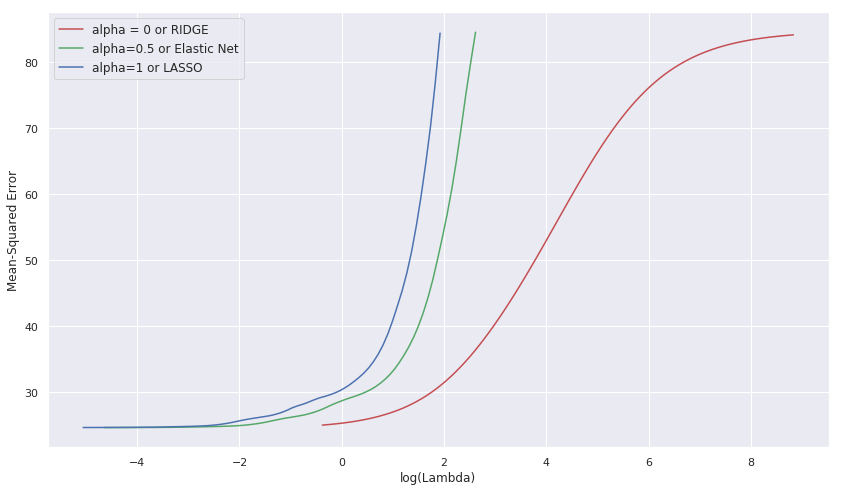

In [24]:
plt.figure(figsize=(14,8))
plt.plot(scipy.log(models['glm0.0']['lambdau']),models['glm0.0']['cvm'],'r')
plt.plot(scipy.log(models['glm0.5']['lambdau']),models['glm0.5']['cvm'],'g')
plt.plot(scipy.log(models['glm1.0']['lambdau']),models['glm1.0']['cvm'],'b')
plt.xlabel(('log(Lambda)'))
plt.ylabel(models['glm1.0']['name'])
plt.legend(('alpha = 0 or RIDGE', 'alpha=0.5 or Elastic Net', 'alpha=1 or LASSO'), loc='upper left',prop={'size':12})

In [25]:
random.seed(34)
predictions=dict(
    [(model_name,
    pd.Series(cvglmnetPredict(model,
                             newx=x_test,
                             s='lambda_min',
                             ptype='link')[:,0],
             name='Prediction'))
    for model_name, model in models.items()])

In [26]:
accuracies = dict(
    [(model_name, 
      sqrt(metrics.mean_squared_error(pd.Series(y_test[:,0]),predictions[model_name])))
     for model_name in models.keys()])

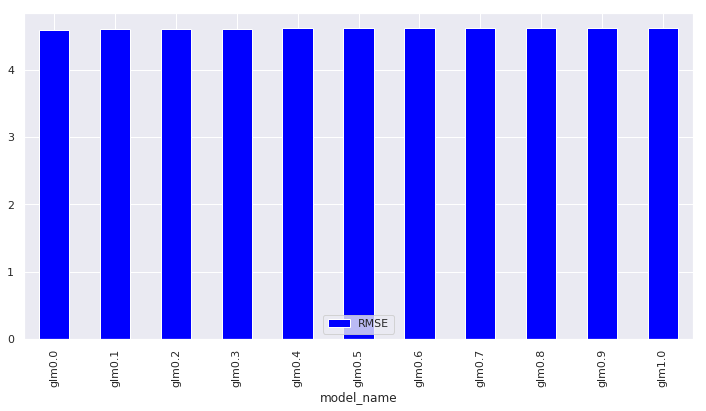

In [27]:
pd.DataFrame(data=[(key,RMSE) for key, RMSE in accuracies.items()], columns=['model_name','RMSE'])\
.plot.bar(x='model_name',y='RMSE',color='blue',figsize=(12,6))

In [28]:
best_alpha = (min(accuracies,key=accuracies.get))
best_RMSE = (min(accuracies.values()))
print(f'The best model is {best_alpha} and scores a RMSE of {round(best_RMSE,4)} on the test set')

The best model is glm0.0 and scores a RMSE of 4.5937 on the test set


# Show best model details

In [29]:
best_coeffs = cvglmnetCoef(models[best_alpha],s='lambda_min')
intercept = best_coeffs[0][0]
varsnames = list(x_df.columns.values)

In [30]:
model_selected = pd.DataFrame(
    data=list(zip(['intercept']+list(x_df.columns),[float(coeff) for coeff in best_coeffs])),
    columns=['feature','beta'])
pd.set_option('display.max_rows',len(model_selected))
model_selected.reindex(model_selected.beta.abs().sort_values(ascending=False).index)

,feature,beta
0,intercept,22.751977
3,INDUS,-3.873285
8,DIS,2.408634
7,AGE,-2.083587
2,ZN,-1.895843
10,TAX,-1.459161
9,RAD,1.386306
12,B,0.998602
5,NOX,0.958810
11,PTRATIO,-0.928578


In [31]:
pd.reset_option('display.max_rows')